In [ ]:
%pip install langchain langchain-google-genai langchain_community tavily-python aiosqlite langchain-tavily 
%pip install langgraph-checkpoint-sqlite 
%pip install langgraph langgraph-checkpoint-sqlite
%pip install langgraph
%pip install langchain pydantic

In [55]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from pydantic import BaseModel
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
import google.genai as genai
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
from typing import TypedDict, List
from tavily import TavilyClient
conn = sqlite3.connect("checkpoints.db", check_same_thread=False)
memory = SqliteSaver(conn)

In [56]:
load_dotenv()
os.environ['GOOGLE_API_KEY'] = os.getenv('GEMINI_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [57]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [58]:

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


In [59]:
PLAN_PROMPT = """Você é um escritor especialista com a tarefa de criar um esboço de alto nível para uma redação. \
Escreva esse esboço para o tópico fornecido pelo usuário. Apresente um plano da redação junto com quaisquer notas \
ou instruções relevantes para as seções."""

In [60]:
WRITER_PROMPT = """Você é um assistente de redação com a tarefa de escrever excelentes redações de 5 parágrafos. \
Gere a melhor redação possível para a solicitação do usuário e o esboço inicial. \
Se o usuário fornecer críticas, responda com uma versão revisada das suas tentativas anteriores. \
Utilize todas as informações abaixo conforme necessário:

------------

{content}"""

In [61]:
REFLECTION_PROMPT = """Você é um professor corrigindo uma redação submetida. \
Gere uma crítica e recomendações para a submissão do usuário. \
Forneça recomendações detalhadas, incluindo pedidos sobre extensão, profundidade, estilo, etc."""

In [62]:
RESEARCH_PLAN_PROMPT = """Você é um pesquisador encarregado de fornecer informações que podem \
ser usadas ao escrever a seguinte redação. Gere uma lista de consultas de pesquisa que \
recolham quaisquer informações relevantes. Gere no máximo 3 consultas."""

In [63]:
RESEARCH_CRITIQUE_PROMPT = """Você é um pesquisador encarregado de fornecer informações que podem \
ser usadas ao fazer quaisquer revisões solicitadas (conforme descrito abaixo). \
Gere uma lista de consultas de pesquisa que recolham quaisquer informações relevantes. Gere no máximo 3 consultas."""

In [77]:
class Queries(BaseModel):
    queries: list[str]

In [65]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [66]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [67]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}"
    )
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }

In [68]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [69]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [70]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [71]:
builder = StateGraph(AgentState)
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)
builder.set_entry_point("planner")

In [72]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)

In [78]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [74]:
graph = builder.compile(checkpointer=memory)


--- Tentando Gerar PNG do Grafo via Mermaid (Requer Playwright!) ---


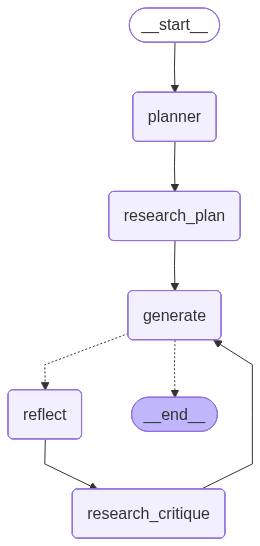

Grafo PNG gerado e exibido com sucesso!


In [75]:
from IPython.display import Image, display, Markdown
import os
print("\n--- Tentando Gerar PNG do Grafo via Mermaid (Requer Playwright!) ---")
try:
    image_data = graph.get_graph().draw_mermaid_png()
    display(Image(data=image_data))
    print("Grafo PNG gerado e exibido com sucesso!")
except Exception as e:
    print(f"Erro ao tentar gerar o PNG do grafo: {e}")
    print("Isso pode ocorrer por:")
    print("1. O método `.draw_mermaid_png()` não existe na sua versão do LangGraph.")
    print("2. Faltam dependências como `playwright` ou seus drivers não foram instalados.")
    print("Tente: pip install playwright && playwright install")
    print("3. Outro erro inesperado ao acessar o grafo ou renderizar.")

    print("\n--- Tentando gerar apenas o código Mermaid (Fallback) ---")
    try:
        mermaid_code = graph.get_graph().draw_mermaid()
        print("\n--- Código Mermaid Gerado (Cole em https://mermaid.live/ ou use Markdown no notebook) ---")
        print(mermaid_code)
    except Exception as e_mermaid:
        print(f"Erro ao gerar código Mermaid: {e_mermaid}")
        print("Verifique se `graph.get_graph()` está correto e acessível.")

In [ ]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    "task": "Qual é a diferença entre o langchain e langsmith",
    "max_revisions": 2,
    "revision_number": 1,
    "content": [],
}, thread):
    print(s)